In [ ]:
!python -m pip install gymnasium

In [ ]:
!python -m pip install tqdm

In [ ]:
!python -m pip install matplotlib

In [1]:
modules = ['random','gymnasium','numpy','collections','tqdm','torch','rl_utils']
for m in modules:
    try:
        __import__(m)
        print(m, 'OK')
    except Exception as e:
        print(m, 'FAILED:', e)
        break

random OK
gymnasium OK
numpy OK
collections OK
tqdm OK
torch OK
rl_utils OK


In [4]:
pip install "numpy<2"

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 12.4 MB/s  0:00:01 eta 0:00:010:01:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
Note: you may need to restart the kernel to use updated packages.


In [5]:
import random
import gymnasium as gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [6]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [7]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [19]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络，第二个网络预测下一个状态的Q值，利于Q网络逼近
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)#返回一个随机的，大小为2的数组
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item() #反函数，argmax(a)Q
        return action#一个大小为2的数组

    def update(self, transition_dict):#传进来一个共500个样本的字典
        #先tensor化并存在cuda上
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)
        q_values = self.q_net(states).gather(1, actions)  # Q值
        #print("actions:",actions),形状是（batchsize,1),因为每个动作是确定的，要么是0，要么是1
        #print("q_net(states):",self.q_net(states))形状是（batchsize,2),因为这个网络的输出大小就是动作空间的大小（2）,表示对应动作取得的价值
        #print("q_values:",q_values)形状是（batchsize,1),因为价值是已经采集到的，是一个数字
        #gather(1, actions) 的作用是：沿着第 1 维（列）从每一行中“按索引取值”，把每个样本对应动作的 Q 值挑出来，得到形状为 (batch_size, 1) 的张量（每行一个值）
        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        #.max(1)[0].view(-1, 1)表示把形状为(batchsize,2)的Q值，沿着第1维（列）选取最大的值，也就是取每行（每个样本）最大的值，并把结果整理成(batchsize,1)的形式
        #print(states.shape, actions.shape, rewards.shape, next_states.shape, dones.shape,max_next_q_values.shape)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数，这里dqn_loss是一个一维张量
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step() #利用梯度更新参数

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 定期更新目标网络
        self.count += 1

In [20]:
# 你的超参数（保持不变）
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)

# 全局随机种子（保持）
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# 给 action_space / observation_space 也设种子（向后兼容）
try:
    #会启用动作随机
    #print("env.action_space.seed(0)",env.action_space.seed(0))
    env.action_space.seed(0)
except Exception:
    pass
try:
    #会启用观测随机
    #print("env.observation_space.seed(0)",env.observation_space.seed(0))
    env.observation_space.seed(0)
except Exception:
    pass

# 不再调用 env.seed(0) —— 改为在第一次 reset 时或每个 episode reset 时传 seed
# 为兼容 gym 和 gymnasium 的 step/reset 接口，定义小 helper：
def env_reset(env, seed=None):
    # Gymnasium: env.reset(seed=...) -> (obs, info)
    if seed is not None:
        res = env.reset(seed=seed)
    else:
        res = env.reset()
    #res类似(array([ 0.01369617, -0.02302133, -0.04590265, -0.04834723], dtype=float32), {})，所以是一个有两个元素的元组
    if isinstance(res, tuple) and len(res) == 2:#会执行
        obs, _info = res
        #print("obs, _info",res)
        return obs
    return res

def env_step(env, action):
    # Gymnasium: step -> (obs, reward, terminated, truncated, info)
    res = env.step(action)
    if isinstance(res, tuple) and len(res) == 5:# 如果是res时 5 元组（gymnasium）
        obs, reward, terminated, truncated, info = res
        done = terminated or truncated
        return obs, reward, done, info
    return res

# 下面保留你原来的 Buffer/Agent 初始化
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
#print("action_dim:",action_dim)#action_dim: 2
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
# 训练循环：在每个 episode 用 env_reset 替代 env.reset
for outer_i in range(10): #分成十次跑，一次跑num_episodes/10个回合
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % outer_i) as pbar:#num_episodes / 10表示总共十个进度条
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            # 可选择为每个 episode 传入不同 seed（方便重现），这里示例统一使用 0
            state = env_reset(env, seed=0) # 获取环境，这个环境时共 4 个变量的列表
            done = False #表示这个episode还没结束，之后可能会自行结束
            while not done:
                action = agent.take_action(state) #利用神经网络，采用ε-贪婪策略选择一个动作
                next_state, reward, done, _ = env_step(env, action) #在环境中模拟推演,next_state是一个四元列表，reward是立即回报是一个数字，done是一个bool
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state #迭代当前状态，方便下一次环境交互
                episode_return += reward #总回报累加，应该是用于后续统计和可视化
                # 当buffer数据的数量超过一定值后,才进行Q网络训练，要不然取不出一个批次的数据
                if replay_buffer.size() > minimal_size:#去一个批次（500个），训练一次
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
                    
            return_list.append(episode_return) #添加本episode回报值，用于后续可视化统计
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * outer_i + i_episode + 1),
                    'return': '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 2:  16%|█████████████████████▊                                                                                                                  | 8/50 [00:06<00:33,  1.27it/s]


KeyboardInterrupt: 

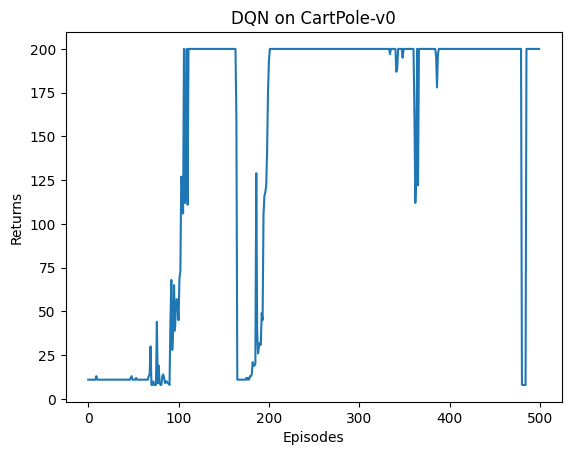

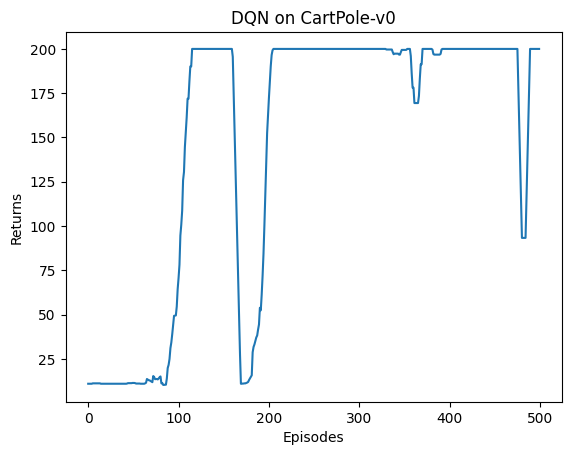

In [15]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)#经过滑动平均（window=9）平滑后的回报曲线，能过滤短期噪声
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [7]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)